`Problem Description`: Power outage accidents will cause huge economic loss. Therefore it is important to predict power consumption.

`Data`: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

`Data Description`: Given the rise of smart electricity generation technology like solar panels, there is wealth of electricity usage data available
The data represents a multivariate time series of power-related variables that in turn could be used to model and even forcast future electricity consumption.
The data was collected between December 2006 and Novemeber 2010 and observations of power consumption within the household were collected every minute.

`Attribute Information`:

- 1.date: Date in format dd/mm/yyyy
- 2.time: time in format hh:mm:ss
- 3.global_active_power: household global minute-averaged active power (in kilowatt)
- 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
- 5.voltage: minute-averaged voltage (in volt)
- 6.global_intensity: household global minute-averaged current intensity (in ampere)
- 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
- 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [0]:
## Libraries
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:
# Load the data
from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [0]:
## Read the data
data = pd.read_csv('household_power_consumption.txt',
                   sep=';',
                   parse_dates = True,
                   low_memory = False,
                #    index_col = 'Date'
                )

In [4]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
## Concatenate 'Date' and 'Time' columns 
data['date_time'] = data['Date'].str.cat(data['Time'], sep = ' ')

## Now Drop 'Date' and 'Time' columns 
data.drop(['Date', 'Time'], inplace = True, axis = 1)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_time
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [6]:
## Set "data_time" column as index
data.set_index(['date_time'], inplace = True)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [0]:
## Repalce '?' with nan
data.replace('?', nan, inplace = True)

In [8]:
## Check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [9]:
## Convert object type to float type
data = data.astype('float')

# check
data.info()

## 
print("\n", data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7+ MB

 (2075259, 7)


In [10]:
## Check for missing value 'nan"
np.isnan(data).sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [0]:
## Fill 'nan' with previous day --- 


def fill_missing(data):
    one_day = 24*60 # minutes
    for  row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row, col]):
                data[row, col] = data[row - one_day, col]

## 
fill_missing(data.values)

In [12]:
## Check missing values 'nan' again
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7+ MB


In [13]:
## Description of data
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [14]:
# shape of data
data.shape

(2075259, 7)

In [15]:
## 
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
16/12/2006 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
16/12/2006 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
16/12/2006 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
16/12/2006 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Prepare power consumption for each day

In [0]:
data.to_csv('cleaned_data.csv')


In [0]:
## Read the cleaned data
dataset = pd.read_csv('cleaned_data.csv', 
                      parse_dates = True,
                      index_col = 'date_time')

In [18]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [19]:
## Power consumption for each day
data = dataset.resample('D').sum()
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


## Exploratory Data Analysis

In [20]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


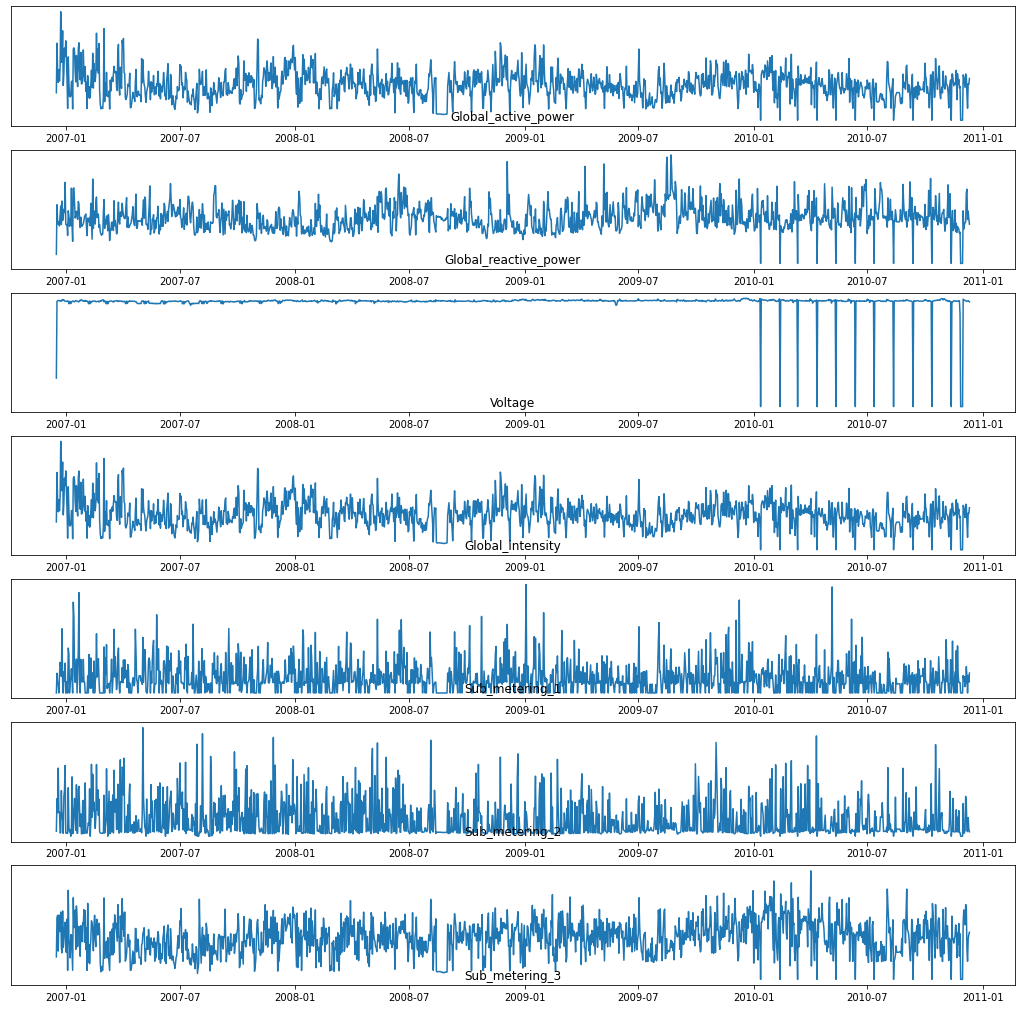

In [21]:
## Plot features for each year
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    plt.plot(data[name])
    plt.title(name, y=0)
    plt.yticks([])
plt.show()
fig.tight_layout()

#### Explore `Global Active Power` consumption for each Year

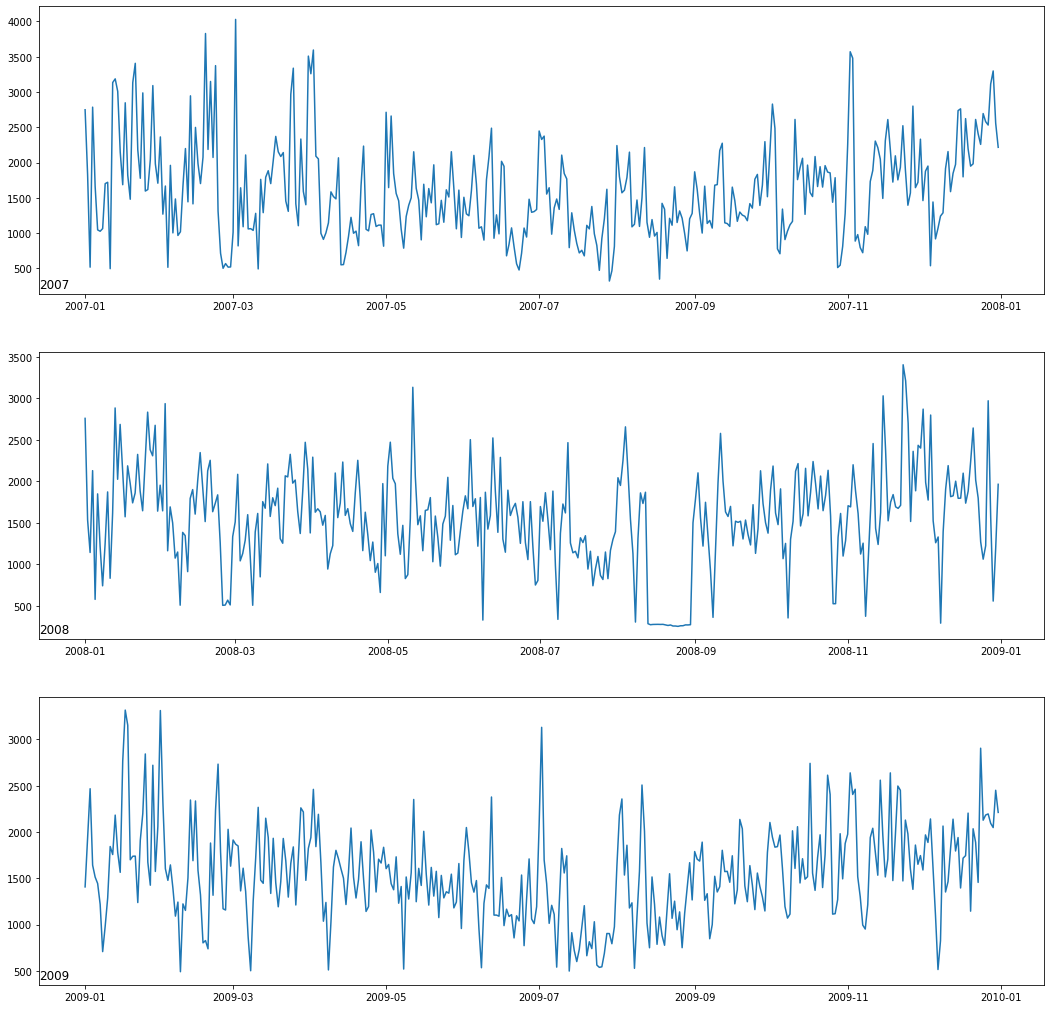

In [22]:
years = ['2007', '2008', '2009']

fig, ax = plt.subplots(figsize=(18, 18))
for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)] ## will get only year
    plt.plot(active_power_data['Global_active_power'])
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

In [0]:
# data['2009']

### Power consumption distribution with histogram

#### Plot power consumption for each year

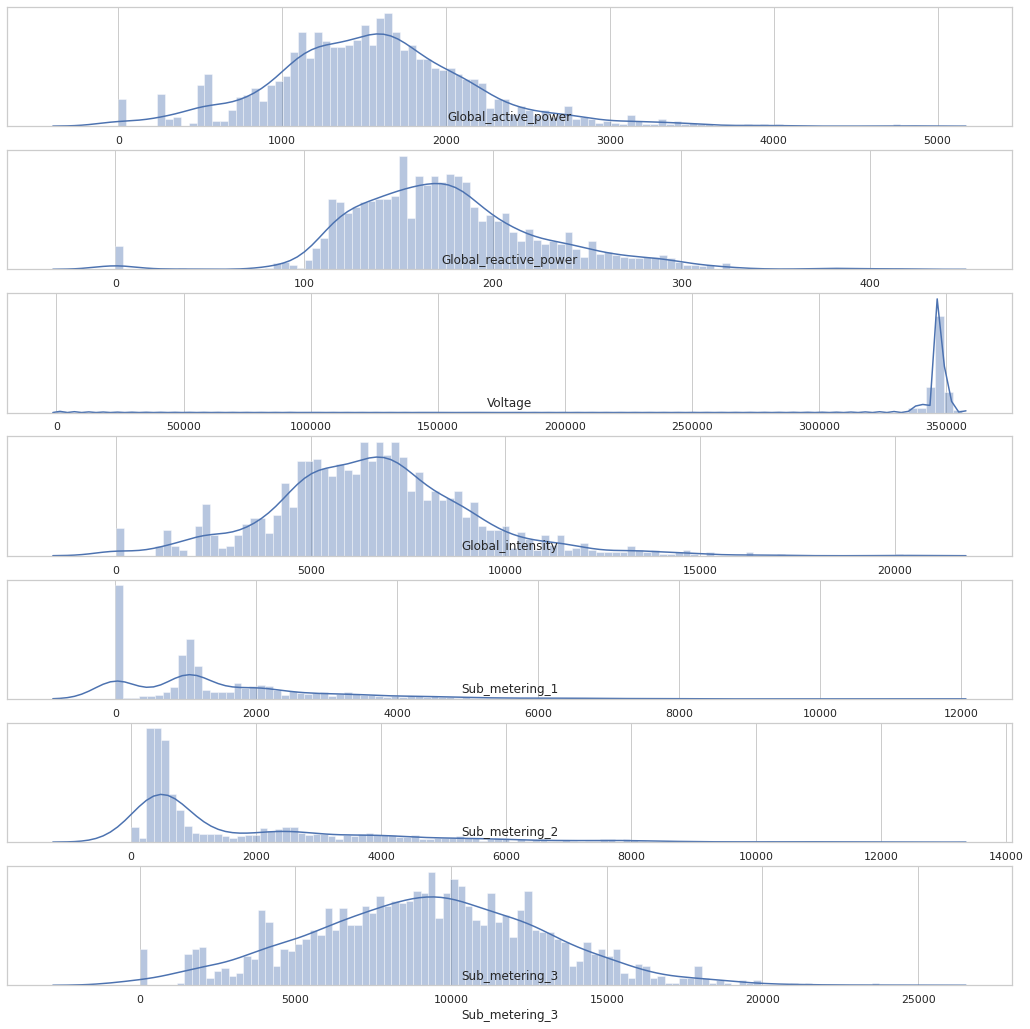

In [24]:
## Plot features for each year
fig, ax = plt.subplots(figsize=(18, 18))
sns.set(style="whitegrid")
for i in range(len(data.columns)):
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    sns.distplot(data[name], bins=100, color="b")
    plt.title(name, y=0)
    plt.yticks([])
plt.show()
fig.tight_layout()

#### Plot power consumption for "Global Active Power"

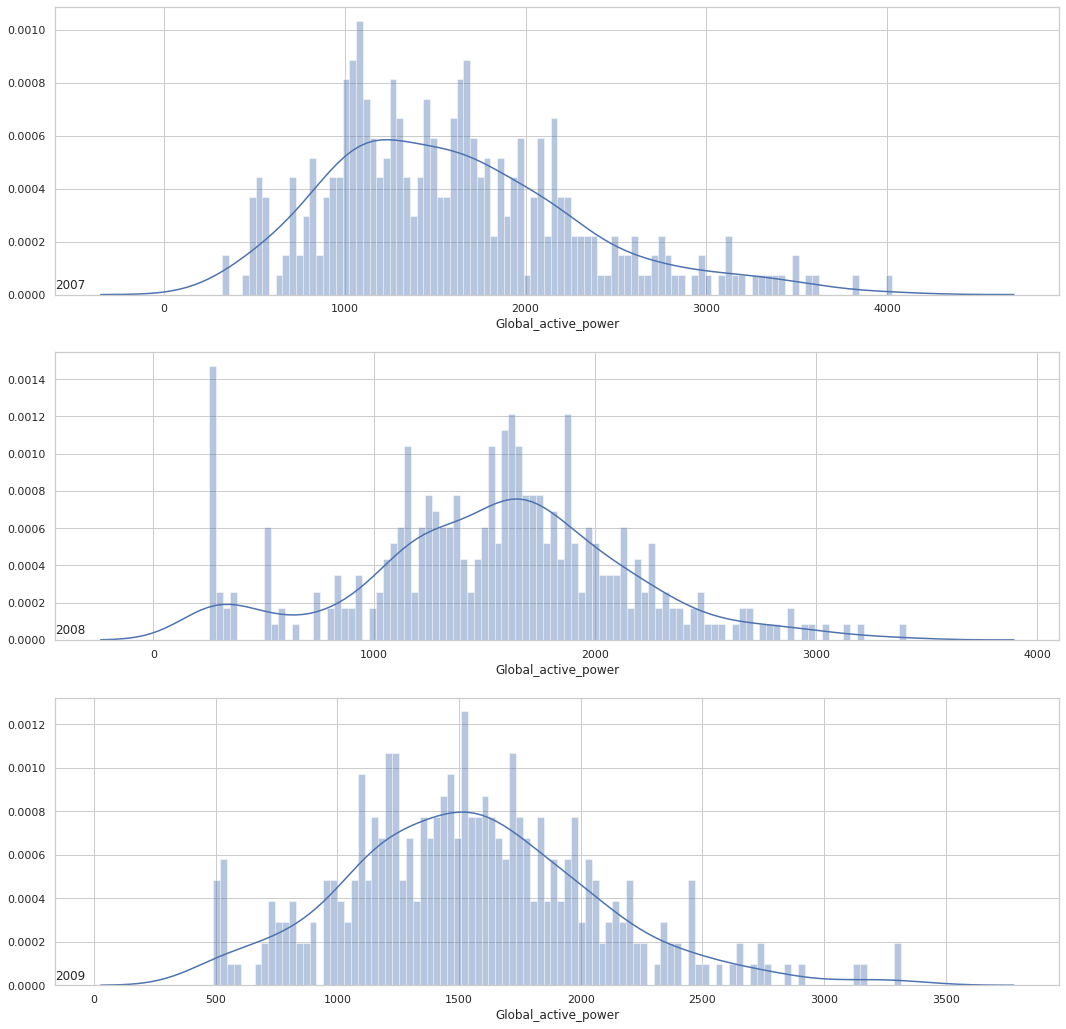

In [25]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(18, 18))
for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)] ## will get only year
    sns.distplot(active_power_data['Global_active_power'], bins=100, color="b")
    plt.title(str(year), y = 0, loc = 'left')
plt.show()
fig.tight_layout()

#### Plot power consumption for each month of 2007

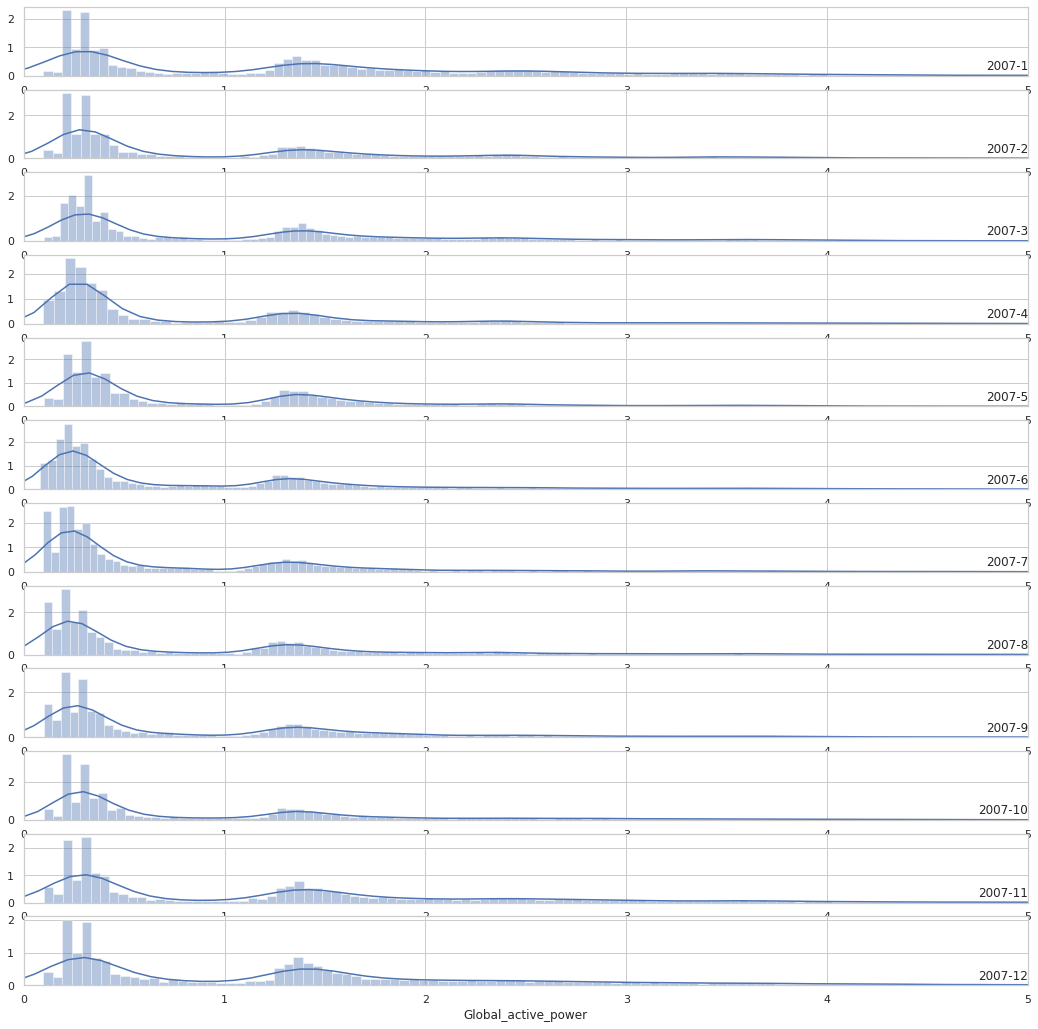

In [26]:
months = [i for i in range(1,13)]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(18, 18))
for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = '2007-' + str(months[i])
    active_power_data = dataset[month]  ## active power for particular month
    sns.distplot(active_power_data['Global_active_power'], bins=200, color="b")
    ax.set_xlim(0,5)
    plt.title(month, y = 0, loc = 'right')
plt.show()
fig.tight_layout()

## Note: Highly concentrated around 0.3 kwh and 1.3 kwh. Power is more consumed 0.3kwh and less 1.3kwh
## It could be bimodal
## Long

### Active power uses Prediction
**What can we predict**
- Forecast hourly consumption for the next day
- Forecast daily consumption for the next week
- Forecast daily consumption for the next month
- Forecast monthly consumption for the next year

#### Problem Framing
- Input -> Predict
- Week 1 -> Week 2
- Week 2 -> Week 3
- Week 3 -> Week 4

In [27]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [28]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,1551.697967,176.172177,343032.233082,6578.159643,1593.084420,1839.005491,9185.029513
std,614.949776,51.844721,35759.251700,2549.274088,1581.929433,2082.860776,3774.129939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1162.226000,141.914000,345672.700000,5005.000000,582.000000,429.000000,6605.000000
50%,1534.652000,170.396000,346958.950000,6508.000000,1111.000000,683.000000,9230.000000
75%,1890.472000,202.392000,348264.250000,7953.400000,2196.000000,2711.000000,11716.000000
max,4773.386000,417.834000,356306.410000,20200.400000,11178.000000,12109.000000,23743.000000


In [29]:
data.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2010-12-07,1109.574,285.912,345914.85,4892.0,1724.0,646.0,6444.0
2010-12-08,529.698,169.098,346744.70,2338.2,0.0,514.0,3982.0
2010-12-09,1612.092,201.358,347932.40,6848.2,1805.0,2080.0,8891.0
2010-12-10,1579.692,170.268,345975.37,6741.2,1104.0,780.0,9812.0
2010-12-11,1836.822,151.144,343926.57,7826.2,2054.0,489.0,10308.0


In [30]:
## Training data
data_train = data.loc[:'2009-12-31', :]['Global_active_power']
# data_train
print(data_train.shape)

(1112,)


In [31]:
## Testting data
data_test = data['2010']['Global_active_power']
# data_test
print(data_test.shape)

(345,)


#### Prepare Training Data

In [32]:
data_train.head(14)

date_time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
2006-12-21    1723.288
2006-12-22    2341.338
2006-12-23    4773.386
2006-12-24    2550.012
2006-12-25    2743.120
2006-12-26    3934.110
2006-12-27    1528.760
2006-12-28    2072.638
2006-12-29    3174.392
Freq: D, Name: Global_active_power, dtype: float64

In [0]:
## data into numpy array
data_train = np.array(data_train)

In [0]:
X_train, y_train = [], []

for i in range(7, len(data_train)-7):
    X_train.append(data_train[i-7 : i])
    y_train.append(data_train[i : i+7])

In [35]:
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(1098, 7) (1098, 7)


In [36]:
## Check this in panda dataframe
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6
0,1209.176,3390.460,2203.826,1666.194,2225.748,1723.288,2341.338
1,3390.460,2203.826,1666.194,2225.748,1723.288,2341.338,4773.386
2,2203.826,1666.194,2225.748,1723.288,2341.338,4773.386,2550.012
3,1666.194,2225.748,1723.288,2341.338,4773.386,2550.012,2743.120
4,2225.748,1723.288,2341.338,4773.386,2550.012,2743.120,3934.110


In [37]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6
0,4773.386,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392
1,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108
2,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196
3,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004
4,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004,1824.760


In [0]:
### Scale the data
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [39]:
# check
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6
0,0.211996,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304
1,0.694252,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000
2,0.431901,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439
3,0.313037,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133
4,0.436748,0.325660,0.462304,1.000000,0.508439,0.551133,0.814446


In [40]:
print(X_train.shape)

(1098, 7)


In [41]:
### LSTM accept 3-dimensional shape

## Reshape
X_train = X_train.reshape(1098, 7, 1)
print(X_train.shape)

(1098, 7, 1)


## Build LSTM model

In [0]:
model = Sequential()
model.add(LSTM(units = 200, activation = 'relu', input_shape = (7,1)))
model.add(Dense(7))

In [0]:
model.compile(loss='mse', optimizer='adam')

In [44]:
model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
35/35 [==============================] - 1s 29ms/step - loss: 0.0622
Epoch 2/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0246
Epoch 3/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0242
Epoch 4/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0241
Epoch 5/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0243
Epoch 6/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0243
Epoch 7/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0241
Epoch 8/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0238
Epoch 9/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0240
Epoch 10/100
35/35 [==============================] - 1s 15ms/step - loss: 0.0238
Epoch 11/100
35/35 [==============================] - 1s 17ms/step - loss: 0.0238
Epoch 12/100
35/35 [==============================] - 1s 16ms/step - loss: 0.0239
Epoch 13/100
35/35 [=====

In [0]:
### Prepare test data
## data into numpy array
data_test = np.array(data_test)

In [46]:
X_test, y_test = [], []

for i in range(7, len(data_test)-7):
    X_test.append(data_test[i-7 : i])
    y_test.append(data_test[i : i+7])


X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(331, 7) (331, 7)


In [0]:
### Scale the data
x_scaler = MinMaxScaler()
X_test = x_scaler.fit_transform(X_test)

y_scaler = MinMaxScaler()
y_test = y_scaler.fit_transform(y_test)

In [48]:
## Check this in panda dataframe
print(pd.DataFrame(X_test).head())

## Check this in panda dataframe
print(pd.DataFrame(y_test).head())

          0         1         2         3         4         5         6
0  0.421718  0.583455  0.447372  0.581272  0.454754  0.437119  0.464690
1  0.583455  0.447372  0.581272  0.454754  0.437119  0.464690  0.191409
2  0.447372  0.581272  0.454754  0.437119  0.464690  0.191409  0.548850
3  0.581272  0.454754  0.437119  0.464690  0.191409  0.548850  0.518365
4  0.454754  0.437119  0.464690  0.191409  0.548850  0.518365  0.476463
          0         1         2         3         4         5         6
0  0.191409  0.548850  0.518365  0.476463  0.000000  0.687491  0.728975
1  0.548850  0.518365  0.476463  0.000000  0.687491  0.728975  0.756717
2  0.518365  0.476463  0.000000  0.687491  0.728975  0.756717  0.740648
3  0.476463  0.000000  0.687491  0.728975  0.756717  0.740648  0.656751
4  0.000000  0.687491  0.728975  0.756717  0.740648  0.656751  0.647981


In [49]:
## Reshape
## Reshape
X_test = X_test.reshape(331, 7, 1)
print(X_test.shape)

(331, 7, 1)


In [50]:
## Prediction
y_pred = model.predict(X_test)
y_pred

array([[0.4110644 , 0.4860567 , 0.43980196, ..., 0.3838639 , 0.39864114,
        0.41239396],
       [0.2924165 , 0.39452142, 0.37496355, ..., 0.36272493, 0.39355347,
        0.37691578],
       [0.40323555, 0.4742518 , 0.4369095 , ..., 0.37634042, 0.38120165,
        0.39575782],
       ...,
       [0.3873818 , 0.4173991 , 0.38222355, ..., 0.29448268, 0.28534544,
        0.31435454],
       [0.41477895, 0.43758476, 0.3884275 , ..., 0.291845  , 0.31102535,
        0.3441142 ],
       [0.4051385 , 0.4115544 , 0.3698633 , ..., 0.30178738, 0.3199912 ,
        0.36374736]], dtype=float32)

In [51]:
## 
y_pred = y_scaler.inverse_transform(y_pred)
y_pred

array([[1193.3257 , 1411.0294 , 1276.7512 , ..., 1114.3623 , 1157.2609 ,
        1197.1854 ],
       [ 848.8892 , 1145.3011 , 1088.5244 , ..., 1052.9956 , 1142.4912 ,
        1094.1918 ],
       [1170.5985 , 1376.7596 , 1268.3544 , ..., 1092.5215 , 1106.6338 ,
        1148.8905 ],
       ...,
       [1124.5747 , 1211.7155 , 1109.6003 , ...,  854.8873 ,  828.3618 ,
         912.5756 ],
       [1204.1091 , 1270.3147 , 1127.6105 , ...,  847.2301 ,  902.91095,
         998.9684 ],
       [1176.1227 , 1194.7482 , 1073.7184 , ...,  876.09296,  928.93896,
        1055.9636 ]], dtype=float32)

In [52]:
y_true = y_scaler.inverse_transform(y_test)
y_true

array([[ 555.664, 1593.318, 1504.82 , ...,    0.   , 1995.796, 2116.224],
       [1593.318, 1504.82 , 1383.18 , ..., 1995.796, 2116.224, 2196.76 ],
       [1504.82 , 1383.18 ,    0.   , ..., 2116.224, 2196.76 , 2150.112],
       ...,
       [1892.998, 1645.424, 1439.426, ..., 1973.382, 1109.574,  529.698],
       [1645.424, 1439.426, 2035.418, ..., 1109.574,  529.698, 1612.092],
       [1439.426, 2035.418, 1973.382, ...,  529.698, 1612.092, 1579.692]])

### Evaluate the LSTM model

In [0]:
def evaluate_model(y_true, y_predicted):
    scores = []

    ## Calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)

    ## Calculate score for whole prediction
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col]) ** 2
    total_score = np.sqrt(total_score/(y_true.shape[0] * y_predicted.shape[1]))

    return total_score, scores

In [54]:
evaluate_model(y_true, y_pred)

(619.0958390732447,
 [618.1727064815308,
  589.3705180460543,
  597.9034550643008,
  591.3872990349313,
  668.2561854149627,
  635.7200149326518,
  628.9107705828167])

In [55]:
### standard deviation
np.std(y_true[0])

710.0253857243853